# Logistic Regression -  Interactive Decision Boundary

This tutorial is similar to the previous one ([Logistic Regression - Keras Implementation](logistic_regression_keras.ipynb)). The only difference is that we show the evolution of the logistic classifier decision boundary throughout the training epochs.

The goals of this tutorial are:
  - Show you the evolution of the decion boundary during training.
  - Introduce you to Keras callbacks.
  
## Importing Python Libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import keras
from keras.utils import np_utils 
from keras.models import Model
from keras.layers import Dense, Activation,Input 
from keras.optimizers import SGD
from keras.callbacks import Callback
import sys
## Adding dataset_utils to the system path so we can import it
MY_UTILS_PATH = '../Modules/'
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import dataset_utils 

/home/roberto/Documents/virtualenv/venv03/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loding and Displaying 2D Dataset

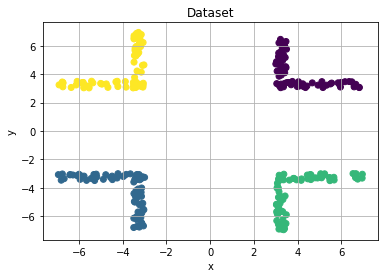

In [2]:
#Generating a synthetic dataset with four classes
nsamples = 300

data = dataset_utils.corners(N = nsamples,scale = 0.5,gapwidth = 3,cornerwidth = 4) # linear dataset

# Separating features (X) and labels (Y)
X = data[:,:-1] # Features
Y = data[:,-1].astype(int) # Labels

#Number of classes
k = np.unique(Y).size

colors = np.array(['r','y','b','g'])
#Displaying the dataset
plt.scatter(X[:,0],X[:,1],c=Y)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Dataset")
plt.grid()
plt.show()

## Data Normalization

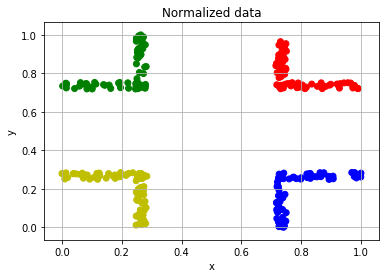

In [3]:
# Range Normalization - normalizing between 0 and 1
X_c = X - X.min(axis=0,keepdims=True)
X_c /= X_c.max(axis=0,keepdims=True)

plt.scatter(X_c[:, 0], X_c[:, 1], c=colors[Y])
plt.title("Normalized data")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

## Representing Labels using one-hot-ecoding

In [4]:
Y_oh = np_utils.to_categorical(Y, k) 

# Displaying the 5 first elemnts
print('Y[:5]:')
print(Y[:5])
print('\nY_oh[:5]=')
print(Y_oh[:5])

Y[:5]:
[0 0 0 0 0]

Y_oh[:5]=
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


## Callback Definition

In [5]:
class BoundaryPlotter(Callback):
    def __init__(self,X,Y,n_epoch, filepath=None,h = .01):
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h),\
                                       np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        
    def on_epoch_end(self,epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
            if epoch%100==0: 
                plt.subplot(121)
                plt.plot(np.arange(epoch+1),self.loss_hist,'b',linewidth = 2.0)
                plt.subplot(122)
                Z = self.model.predict(self.X_grid,verbose=0).argmax(axis =1)
                Z=Z.reshape(self.xx.shape)
                plt.figure(1, figsize=(4, 3))
                plt.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b','g'])
                plt.scatter(self.X[:, 0], self.X[:, 1], s=400,\
                            c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)
                
                display.display(plt.gcf())
                display.clear_output(wait=True)
                

## Defining the Logistic Regression Classifier with Keras

In [6]:
def my_model(k,learning_rate = 0.05):
    inputs = Input(shape=(2,))
    out1 = Dense(k, activation='softmax', kernel_initializer="zero")(inputs)
    model = Model(inputs=inputs, outputs=out1)
    sgd = SGD(lr=learning_rate)
    model.compile(optimizer=sgd, loss='categorical_crossentropy') 
    return model

## Training the Model and Showing the Decision Boundary Evolution

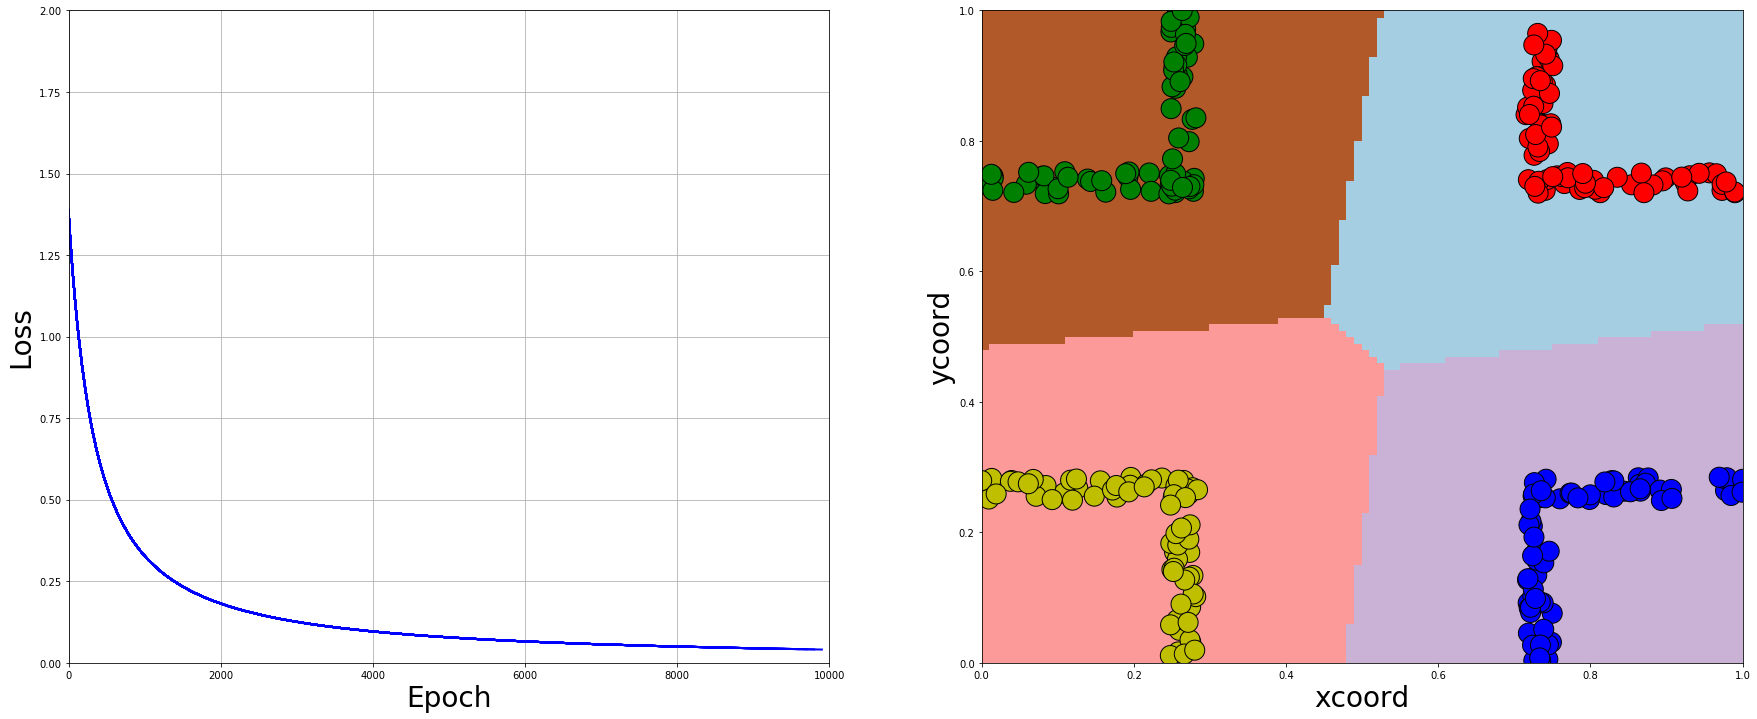

In [7]:
model = my_model(k)
batch_size = nsamples
nb_epoch = 10000
n = X_c.shape[0] # number of training examples

batch_size = 150
nb_epoch = 10000

#Defining the callback
boundary_plot = BoundaryPlotter(X_c,Y,nb_epoch)

#Callback plots
ploss = 2.0
fig = plt.figure(figsize=(30,12))
plt.subplot(121)
plt.ylim(0.0, ploss)
plt.xlim(0, nb_epoch)
plt.xlabel('Epoch',fontsize=28)
plt.ylabel('Loss',fontsize=28)
plt.plot(-1,-1,'b',linewidth = 2.0,label = "Train")
plt.grid(True)

plt.subplot(122)
plt.xlim(X_c[:,0].min(), X_c[:,0].max())
plt.ylim(X_c[:,1].min(), X_c[:,1].max())
plt.xlabel('xcoord',fontsize=28)
plt.ylabel('ycoord',fontsize=28)

try:
    history = model.fit(X_c, Y_oh, batch_size=batch_size, epochs=nb_epoch,callbacks = [boundary_plot],verbose=0)
except KeyboardInterrupt:
    pass

## Prininting Loss and estimated weights (Ws)

In [8]:
loss = model.evaluate(X, Y_oh, verbose=0)
print 'Final loss:',loss

W = model.get_weights()
print 'Bias:\n', W[1]
print 'W:\n', W[0]

Final loss: 1.0000000494736474e-07
Bias:
[-5.8046398   6.73709344 -0.45579735 -0.47665629]
W:
[[ 6.35904735 -6.65073809  8.52558698 -8.23389624]
 [ 6.24254892 -6.52133069 -8.24711305  8.52589482]]


## Training Accuracy

In [9]:
Y_hat = model.predict(X).argmax(axis = 1)
accuracy = np.sum(Y_hat == Y)/np.float(n)
print
print 'Accuracy: ', accuracy


Accuracy:  1.0
